<center><img src=https://github.com/nccr-itmo/FEDOT/raw/master/docs/fedot_logo.png></img></center>

# <center>Использование эволюционного алгоритма в фреймоврке автоматического машинного обучения [FEDOT](https://github.com/nccr-itmo/FEDOT)</center>

## Введение

Для решения любой задачи при помощи методов машинного обучения, исследователю требуется пройти множество шагов: от предобработки данных, выбора наиболее качественных признаков, преобразования признаков, подбора модели и до настройка гиперпараметров для запуска.

Концепция задач **автоматического машинного обучения (AutoML)** направлена на уменьшении (или даже в полном исключении) участия человека в процессе решения задач машинного обучения. На основе доступных данных (обучающей выборки) осуществляется поиск оптимального **пайплайна** (последовательности действий над данными и моделей для предсказания) для наиболее лучшего решения задачи.

<center><img src=https://habrastorage.org/r/w1560/webt/5r/9t/sd/5r9tsdb-inbszzrmy_jnmpphiwe.png></img></center>

**FEDOT** - это фреймворк с открытым исходным кодом автоматического машинного обучения, который способен автоматизировать создание и оптимизацию пайплайнов машинного обучения и их элементов. 
Фреймворк позволяет компактно и эффективно решать различные задачи моделирования.

### Установка FEDOT

Наиболее простой способ установки фреймворка **FEDOT** через `pip`:

In [ ]:
# !pip install fedot

Однако, на данный момент, мы рекомендуем вам его установить напрямую из master ветки репозитория:

In [ ]:
!pip install https://github.com/nccr-itmo/FEDOT/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/nccr-itmo/FEDOT/archive/master.zip
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/aimclub/GOLEM.git (to revision stable) to /tmp/pip-install-zt0vcwds/thegolem_a02e1fbddf644305af40697b9ba2898f
  Running command git clone --filter=blob:none --quiet https://github.com/aimclub/GOLEM.git /tmp/pip-install-zt0vcwds/thegolem_a02e1fbddf644305af40697b9ba2898f
  Running command git checkout -b stable --track origin/stable
  Switched to a new branch 'stable'
  Branch 'stable' set up to track remote branch 'stable' from 'origin'.
  Resolved https://github.com/aimclub/GOLEM.git to commit 462b0eaa71eed322783b6a8876d1d13501e8a546
  Preparing metadata (setup.py) ... done


<div class="alert alert-block alert-info"><b>Примечание</b>: существуют альтернативные способы установки фреймворка и его зависимостей, с которыми можно ознакомится в разделе <b><a href="https://fedot.readthedocs.io/en/latest/introduction/tutorial/quickstart.html">Quickstart</a></b> в нашей документации.</div>

Импортируем все необходимые объекты для дальнейшего запуска кода.

In [ ]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go

from itertools import cycle
from scipy.io.arff import loadarff 
from sklearn.model_selection import train_test_split
from typing import Sequence, Optional
from datetime import timedelta
from matplotlib import pyplot as plt
from PIL import ImageColor

from golem.core.optimisers.genetic.gp_params import GPAlgorithmParameters
from golem.core.optimisers.genetic.operators.inheritance import GeneticSchemeTypesEnum
from golem.core.optimisers.genetic.operators.selection import SelectionTypesEnum
from golem.core.tuning.sequential import SequentialTuner
from golem.core.optimisers.genetic.operators.mutation import MutationTypesEnum
from golem.core.optimisers.genetic.operators.crossover import CrossoverTypesEnum
from golem.core.optimisers.opt_history_objects.opt_history import OptHistory

from fedot.core.pipelines.pipeline_composer_requirements import PipelineComposerRequirements
from golem.visualisation.opt_viz_extra import OptHistoryExtraVisualizer
from sklearn.metrics import roc_auc_score as roc_auc

from fedot.core.composer.composer_builder import ComposerBuilder
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot.core.data.data import InputData
from fedot.core.pipelines.node import PipelineNode
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.operation_types_repository import get_operations_for_task
from fedot.core.repository.quality_metrics_repository import ClassificationMetricsEnum, ComplexityMetricsEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum
from fedot.core.optimisers.objective.metrics_objective import MetricsObjective
from fedot.core.pipelines.pipeline_graph_generation_params import get_pipeline_generation_params

### Данные

В качестве примера задачи классификации возьмем данные из OpenML [KC2](https://www.openml.org/search?type=data&sort=runs&id=1063&status=active). В датасете NASA Metrics Data Programm состоят из анализа дефектов программного обеспечения.

Загрузим данные со страницы OpenML репозитория:

In [ ]:
!wget -nc https://datahub.io/machine-learning/kc2/r/kc2.csv

--2023-03-16 12:44:02--  https://datahub.io/machine-learning/kc2/r/kc2.csv
Resolving datahub.io (datahub.io)... 104.21.40.221, 172.67.157.38, 2606:4700:3033::6815:28dd, ...
Connecting to datahub.io (datahub.io)|104.21.40.221|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/kc2/kc2_csv/data/34d7afeac94b3404c546add07ce9c84b/kc2_csv.csv [following]
--2023-03-16 12:44:03--  https://pkgstore.datahub.io/machine-learning/kc2/kc2_csv/data/34d7afeac94b3404c546add07ce9c84b/kc2_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.21.40.221, 172.67.157.38, 2606:4700:3030::ac43:9d26, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.21.40.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39824 (39K) [text/csv]
Saving to: ‘kc2.csv’

kc2.csv             100%[===================>]  38.89K  --.-KB/s    in 0.001s  

2023-03-16 12:44:03 (35.1 MB/s) - ‘kc2.csv’ saved [39824/39

In [ ]:
train_df = pd.read_csv('kc2.csv')

Аттрибуты признаков:
* loc : numeric % McCabe's line count of code
* v(g) : numeric % McCabe "cyclomatic complexity"
* ev(g) : numeric % McCabe "essential complexity"
* iv(g) : numeric % McCabe "design complexity"
* n : numeric % Halstead total operators + operands
* v : numeric % Halstead "volume"
* l : numeric % Halstead "program length"
* d : numeric % Halstead "difficulty"
* i : numeric % Halstead "intelligence"
* e : numeric % Halstead "effort"
* b : numeric % Halstead
* t : numeric % Halstead's time estimator
* lOCode : numeric % Halstead's line count
* lOComment : numeric % Halstead's count of lines of comments
* lOBlank : numeric % Halstead's count of blank lines
* lOCodeAndComment: numeric
* uniq_Op : numeric % unique operators
* uniq_Opnd : numeric % unique operands
* total_Op : numeric % total operators
* total_Opnd : numeric % total operands
* branchCount : numeric % of the flow graph
* problems : {false,true} % module has/has not one or more reported defects

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   loc               522 non-null    float64
 1   v(g)              522 non-null    float64
 2   ev(g)             522 non-null    float64
 3   iv(g)             522 non-null    float64
 4   n                 522 non-null    float64
 5   v                 522 non-null    float64
 6   l                 522 non-null    float64
 7   d                 522 non-null    float64
 8   i                 522 non-null    float64
 9   e                 522 non-null    float64
 10  b                 522 non-null    float64
 11  t                 522 non-null    float64
 12  lOCode            522 non-null    int64  
 13  lOComment         522 non-null    int64  
 14  lOBlank           522 non-null    int64  
 15  lOCodeAndComment  522 non-null    int64  
 16  uniq_Op           522 non-null    float64
 1

In [ ]:
train, test = train_test_split(train_df, random_state=42)

train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

print(train.shape, test.shape)
print('')
print(train.problems.value_counts())
print(test.problems.value_counts())

(391, 22) (131, 22)

no     312
yes     79
Name: problems, dtype: int64
no     103
yes     28
Name: problems, dtype: int64


Теперь мы готовы приступить к подготовке алгоритма

## Подготовка алгоритма

Данные необходимо обернуть в объект `InputData`:

In [ ]:
train_data = InputData.from_csv('train.csv', target_columns='problems')
test_data = InputData.from_csv('test.csv', target_columns='problems')

Определим решаемую задачу и набор доступных моделей:

In [ ]:
task = Task(TaskTypesEnum.classification)
available_model_types = get_operations_for_task(task=task, mode='model')

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


2023-03-16 12:44:17,559 - 'pattern' package not found; tag filters are not available for English


Следующее, что нам необходимо, это объявить метрики и дать понять фреймворку оптимизировать ее:

In [ ]:
quality_metric = ClassificationMetricsEnum.ROCAUC

objective = MetricsObjective(quality_metric)

Определим необходимые требования для пайплайнов в композере

In [ ]:
composer_requirements = PipelineComposerRequirements(
        primary=available_model_types,
        secondary=available_model_types,
        # timeout=timedelta(minutes=5),
        num_of_generations=20
)

In [ ]:
pipeline_generation_params = get_pipeline_generation_params(
    requirements=composer_requirements
)

## Random Search


Сперва проверим то, как получаются пайплайны если их искать случайно

In [ ]:
from golem.core.optimisers.random.random_search import RandomSearchOptimizer
from fedot.core.composer.random_composer import RandomSearchComposer

Объявим оптимизатор использующий метод случайного поиска

In [ ]:
optimiser = RandomSearchOptimizer(
    objective,
    requirements=composer_requirements,
    graph_generation_params=pipeline_generation_params
)

И композер со случайным поиском

In [ ]:
random_composer = RandomSearchComposer(optimiser)

Найдем оптимальный граф на обучающих данных, преобразуем его в пайплайн и обучим

In [ ]:
opt_graph_random_composed = random_composer.compose_pipeline(train_data)

pipeline_random_composed = pipeline_generation_params.adapter.restore(opt_graph_random_composed)
pipeline_random_composed.fit(train_data);

INFO:root:RandomSearchOptimizer - Spent time: 0.0 min


2023-03-16 12:44:20,379 - RandomSearchOptimizer - Spent time: 0.0 min


INFO:root:RandomSearchOptimizer - Iteration num 0: Best individual fitness <roc_auc=-0.863>


2023-03-16 12:44:20,398 - RandomSearchOptimizer - Iteration num 0: Best individual fitness <roc_auc=-0.863>


INFO:root:RandomSearchOptimizer - Spent time: 0.1 min


2023-03-16 12:44:21,818 - RandomSearchOptimizer - Spent time: 0.1 min


INFO:root:RandomSearchOptimizer - Iteration num 0: Best individual fitness <roc_auc=-0.863>


2023-03-16 12:44:21,826 - RandomSearchOptimizer - Iteration num 0: Best individual fitness <roc_auc=-0.863>


INFO:root:RandomSearchOptimizer - Spent time: 0.1 min


2023-03-16 12:44:23,982 - RandomSearchOptimizer - Spent time: 0.1 min


INFO:root:RandomSearchOptimizer - Iteration num 1: Best individual fitness <roc_auc=-0.863>


2023-03-16 12:44:24,009 - RandomSearchOptimizer - Iteration num 1: Best individual fitness <roc_auc=-0.863>


INFO:root:RandomSearchOptimizer - Spent time: 0.1 min


2023-03-16 12:44:25,509 - RandomSearchOptimizer - Spent time: 0.1 min


INFO:root:RandomSearchOptimizer - Iteration num 2: Best individual fitness <roc_auc=-0.863>


2023-03-16 12:44:25,520 - RandomSearchOptimizer - Iteration num 2: Best individual fitness <roc_auc=-0.863>


INFO:root:RandomSearchOptimizer - Spent time: 0.2 min


2023-03-16 12:44:30,157 - RandomSearchOptimizer - Spent time: 0.2 min


INFO:root:RandomSearchOptimizer - Iteration num 3: Best individual fitness <roc_auc=-0.863>


2023-03-16 12:44:30,184 - RandomSearchOptimizer - Iteration num 3: Best individual fitness <roc_auc=-0.863>


INFO:root:RandomSearchOptimizer - Spent time: 0.2 min


2023-03-16 12:44:33,058 - RandomSearchOptimizer - Spent time: 0.2 min


INFO:root:RandomSearchOptimizer - Iteration num 4: Best individual fitness <roc_auc=-0.863>


2023-03-16 12:44:33,066 - RandomSearchOptimizer - Iteration num 4: Best individual fitness <roc_auc=-0.863>


INFO:root:RandomSearchOptimizer - Spent time: 0.3 min


2023-03-16 12:44:34,808 - RandomSearchOptimizer - Spent time: 0.3 min


INFO:root:RandomSearchOptimizer - Iteration num 5: Best individual fitness <roc_auc=-0.863>


2023-03-16 12:44:34,822 - RandomSearchOptimizer - Iteration num 5: Best individual fitness <roc_auc=-0.863>


INFO:root:RandomSearchOptimizer - Spent time: 0.3 min


2023-03-16 12:44:38,121 - RandomSearchOptimizer - Spent time: 0.3 min


INFO:root:RandomSearchOptimizer - Iteration num 6: Best individual fitness <roc_auc=-0.863>


2023-03-16 12:44:38,130 - RandomSearchOptimizer - Iteration num 6: Best individual fitness <roc_auc=-0.863>


INFO:root:RandomSearchOptimizer - Spent time: 0.3 min


2023-03-16 12:44:38,630 - RandomSearchOptimizer - Spent time: 0.3 min


INFO:root:RandomSearchOptimizer - Iteration num 7: Best individual fitness <roc_auc=-0.863>


2023-03-16 12:44:38,638 - RandomSearchOptimizer - Iteration num 7: Best individual fitness <roc_auc=-0.863>


INFO:root:RandomSearchOptimizer - Spent time: 0.3 min


2023-03-16 12:44:39,067 - RandomSearchOptimizer - Spent time: 0.3 min


INFO:root:RandomSearchOptimizer - Iteration num 8: Best individual fitness <roc_auc=-0.863>


2023-03-16 12:44:39,079 - RandomSearchOptimizer - Iteration num 8: Best individual fitness <roc_auc=-0.863>


INFO:root:RandomSearchOptimizer - Spent time: 0.4 min


2023-03-16 12:44:40,325 - RandomSearchOptimizer - Spent time: 0.4 min


INFO:root:RandomSearchOptimizer - Iteration num 9: Best individual fitness <roc_auc=-0.863>


2023-03-16 12:44:40,333 - RandomSearchOptimizer - Iteration num 9: Best individual fitness <roc_auc=-0.863>


INFO:root:RandomSearchOptimizer - Spent time: 0.4 min


2023-03-16 12:44:40,773 - RandomSearchOptimizer - Spent time: 0.4 min


INFO:root:RandomSearchOptimizer - Iteration num 10: Best individual fitness <roc_auc=-0.863>


2023-03-16 12:44:40,781 - RandomSearchOptimizer - Iteration num 10: Best individual fitness <roc_auc=-0.863>


INFO:root:RandomSearchOptimizer - Spent time: 0.4 min


2023-03-16 12:44:41,446 - RandomSearchOptimizer - Spent time: 0.4 min


INFO:root:RandomSearchOptimizer - Iteration num 11: Best individual fitness <roc_auc=-0.863>


2023-03-16 12:44:41,452 - RandomSearchOptimizer - Iteration num 11: Best individual fitness <roc_auc=-0.863>


INFO:root:RandomSearchOptimizer - Spent time: 0.4 min


2023-03-16 12:44:41,976 - RandomSearchOptimizer - Spent time: 0.4 min


INFO:root:RandomSearchOptimizer - Iteration num 12: Best individual fitness <roc_auc=-0.884>


2023-03-16 12:44:41,981 - RandomSearchOptimizer - Iteration num 12: Best individual fitness <roc_auc=-0.884>


INFO:root:RandomSearchOptimizer - Spent time: 0.4 min


2023-03-16 12:44:42,390 - RandomSearchOptimizer - Spent time: 0.4 min


INFO:root:RandomSearchOptimizer - Iteration num 13: Best individual fitness <roc_auc=-0.884>


2023-03-16 12:44:42,396 - RandomSearchOptimizer - Iteration num 13: Best individual fitness <roc_auc=-0.884>


INFO:root:RandomSearchOptimizer - Spent time: 0.4 min


2023-03-16 12:44:42,799 - RandomSearchOptimizer - Spent time: 0.4 min


INFO:root:RandomSearchOptimizer - Iteration num 14: Best individual fitness <roc_auc=-0.884>


2023-03-16 12:44:42,810 - RandomSearchOptimizer - Iteration num 14: Best individual fitness <roc_auc=-0.884>


INFO:root:RandomSearchOptimizer - Spent time: 0.4 min


2023-03-16 12:44:43,758 - RandomSearchOptimizer - Spent time: 0.4 min


INFO:root:RandomSearchOptimizer - Iteration num 15: Best individual fitness <roc_auc=-0.884>


2023-03-16 12:44:43,763 - RandomSearchOptimizer - Iteration num 15: Best individual fitness <roc_auc=-0.884>


INFO:root:RandomSearchOptimizer - Spent time: 0.4 min


2023-03-16 12:44:44,678 - RandomSearchOptimizer - Spent time: 0.4 min


INFO:root:RandomSearchOptimizer - Iteration num 16: Best individual fitness <roc_auc=-0.884>


2023-03-16 12:44:44,689 - RandomSearchOptimizer - Iteration num 16: Best individual fitness <roc_auc=-0.884>


INFO:root:RandomSearchOptimizer - Spent time: 0.4 min


2023-03-16 12:44:45,200 - RandomSearchOptimizer - Spent time: 0.4 min


INFO:root:RandomSearchOptimizer - Iteration num 17: Best individual fitness <roc_auc=-0.884>


2023-03-16 12:44:45,207 - RandomSearchOptimizer - Iteration num 17: Best individual fitness <roc_auc=-0.884>


INFO:root:RandomSearchOptimizer - Spent time: 0.5 min


2023-03-16 12:44:46,717 - RandomSearchOptimizer - Spent time: 0.5 min


INFO:root:RandomSearchOptimizer - Iteration num 18: Best individual fitness <roc_auc=-0.884>


2023-03-16 12:44:46,722 - RandomSearchOptimizer - Iteration num 18: Best individual fitness <roc_auc=-0.884>


INFO:root:RandomSearchOptimizer - Spent time: 0.5 min


2023-03-16 12:44:47,526 - RandomSearchOptimizer - Spent time: 0.5 min


INFO:root:RandomSearchOptimizer - Iteration num 19: Best individual fitness <roc_auc=-0.884>


2023-03-16 12:44:47,531 - RandomSearchOptimizer - Iteration num 19: Best individual fitness <roc_auc=-0.884>


CRITICAL:root:GroupedCondition - Optimisation stopped: Max number of iterations reached


2023-03-16 12:44:47,536 - GroupedCondition - Optimisation stopped: Max number of iterations reached


INFO:root:OptimisationTimer - Composition time: 0.482 min


2023-03-16 12:44:47,540 - OptimisationTimer - Composition time: 0.482 min


INFO:root:RandomSearchOptimizer - Spent time: 0.5 min


2023-03-16 12:44:47,543 - RandomSearchOptimizer - Spent time: 0.5 min


INFO:root:RandomSearchOptimizer - Iteration num 20: Best individual fitness <roc_auc=-0.884>


2023-03-16 12:44:47,545 - RandomSearchOptimizer - Iteration num 20: Best individual fitness <roc_auc=-0.884>


Теперь посмотрим оценку метрики на валидационной выборке

In [ ]:
predicted_random_composed = pipeline_random_composed.predict(test_data)

roc_on_valid_random_composed = roc_auc(
    y_true=test_data.target,
    y_score=predicted_random_composed.predict
)

print('ROC-AUC:', roc_on_valid_random_composed)

ROC-AUC: 0.7437586685159501


И по истории посмотрим на то, как менялся fitness на каждой генерации

INFO:root:FitnessLine - Visualizing optimization history... It may take some time, depending on the history size.


2023-03-16 12:44:47,772 - FitnessLine - Visualizing optimization history... It may take some time, depending on the history size.


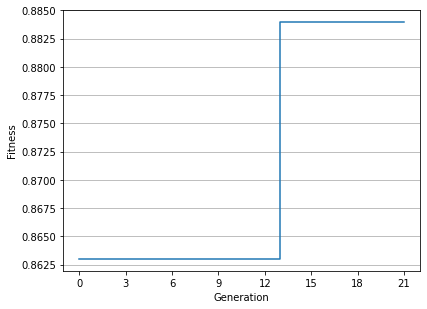

In [ ]:
random_composer.history.show()

## Parameter free

Далее попробуем уже запустить генетический алгоритм. Для этого передадим в `GPAlgorithmParameters` размер популяции `pop_size` и генетическую схему, в нашем случае `parameter_free`

In [ ]:
params = GPAlgorithmParameters(
    pop_size=15,
    genetic_scheme_type=GeneticSchemeTypesEnum.parameter_free
)

После объявим новый композер, использующий параметры `composer_requirements` описанные выше, и добавим параметры для оптимизатора из ячейки выше. 

В конце, запустим поиск оптимального пайплайна:

In [ ]:
gp_composer = ComposerBuilder(task=task) \
        .with_optimizer_params(params) \
        .with_requirements(composer_requirements) \
        .with_metrics(quality_metric) \
        .build()

pipeline_gp_composed = gp_composer.compose_pipeline(train_data)

INFO:root:DataSourceSplitter - Hold out validation is applied.


2023-03-16 12:44:48,444 - DataSourceSplitter - Hold out validation is applied.


Generations:   5%|▌         | 1/20 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-16 12:44:48,459 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 15 individuals out of 15 in previous population were evaluated successfully.


2023-03-16 12:44:59,685 - MultiprocessingDispatcher - 15 individuals out of 15 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 1 size: 15


2023-03-16 12:44:59,720 - EvoGraphOptimizer - Generation num: 1 size: 15


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.881 node_number=0.300>']


2023-03-16 12:44:59,727 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.881 node_number=0.300>']


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-16 12:45:00,086 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.


2023-03-16 12:45:03,940 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 2 size: 21


2023-03-16 12:45:03,968 - EvoGraphOptimizer - Generation num: 2 size: 21


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.882 node_number=0.500>']


2023-03-16 12:45:03,973 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.882 node_number=0.500>']


INFO:root:EvoGraphOptimizer - Next population size: 21; max graph depth: 3


2023-03-16 12:45:03,978 - EvoGraphOptimizer - Next population size: 21; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-16 12:45:04,493 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 12:45:18,475 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 3 size: 21


2023-03-16 12:45:18,501 - EvoGraphOptimizer - Generation num: 3 size: 21


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.882 node_number=0.500>']


2023-03-16 12:45:18,505 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.882 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 12:45:18,509 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2023-03-16 12:45:18,513 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 34; max graph depth: 3


2023-03-16 12:45:18,516 - EvoGraphOptimizer - Next population size: 34; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-16 12:45:19,004 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 12:45:31,950 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 4 size: 34


2023-03-16 12:45:31,989 - EvoGraphOptimizer - Generation num: 4 size: 34


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.882 node_number=0.500>']


2023-03-16 12:45:31,994 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.882 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-16 12:45:31,997 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.7 min


2023-03-16 12:45:32,003 - EvoGraphOptimizer - spent time: 0.7 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 3


2023-03-16 12:45:32,010 - EvoGraphOptimizer - Next population size: 55; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-16 12:45:32,690 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.


2023-03-16 12:45:55,087 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 5 size: 55


2023-03-16 12:45:55,147 - EvoGraphOptimizer - Generation num: 5 size: 55


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.882 node_number=0.500>']


2023-03-16 12:45:55,151 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.882 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-03-16 12:45:55,155 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.1 min


2023-03-16 12:45:55,159 - EvoGraphOptimizer - spent time: 1.1 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 3


2023-03-16 12:45:55,162 - EvoGraphOptimizer - Next population size: 55; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-16 12:45:56,184 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.


2023-03-16 12:46:35,553 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 6 size: 55


2023-03-16 12:46:35,619 - EvoGraphOptimizer - Generation num: 6 size: 55


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.882 node_number=0.500>']


2023-03-16 12:46:35,625 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.882 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 4 iterations


2023-03-16 12:46:35,631 - EvoGraphOptimizer - no improvements for 4 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.8 min


2023-03-16 12:46:35,634 - EvoGraphOptimizer - spent time: 1.8 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 3


2023-03-16 12:46:35,637 - EvoGraphOptimizer - Next population size: 55; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-16 12:46:36,659 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.


2023-03-16 12:47:18,611 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 7 size: 55


2023-03-16 12:47:18,678 - EvoGraphOptimizer - Generation num: 7 size: 55


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.896 node_number=0.500>']


2023-03-16 12:47:18,685 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.896 node_number=0.500>']


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 3


2023-03-16 12:47:18,689 - EvoGraphOptimizer - Next population size: 55; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-16 12:47:19,751 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.


2023-03-16 12:48:01,680 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 8 size: 55


2023-03-16 12:48:01,753 - EvoGraphOptimizer - Generation num: 8 size: 55


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.896 node_number=0.500>']


2023-03-16 12:48:01,758 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.896 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 12:48:01,763 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 3.2 min


2023-03-16 12:48:01,765 - EvoGraphOptimizer - spent time: 3.2 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 3


2023-03-16 12:48:01,769 - EvoGraphOptimizer - Next population size: 55; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-16 12:48:02,785 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.


2023-03-16 12:48:49,577 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 9 size: 55


2023-03-16 12:48:49,646 - EvoGraphOptimizer - Generation num: 9 size: 55


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.896 node_number=0.500>']


2023-03-16 12:48:49,650 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.896 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-16 12:48:49,655 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 4.0 min


2023-03-16 12:48:49,659 - EvoGraphOptimizer - spent time: 4.0 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 3


2023-03-16 12:48:49,662 - EvoGraphOptimizer - Next population size: 55; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-16 12:48:50,528 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.


2023-03-16 12:49:32,131 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 10 size: 55


2023-03-16 12:49:32,196 - EvoGraphOptimizer - Generation num: 10 size: 55


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.896 node_number=0.500>']


2023-03-16 12:49:32,200 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.896 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-03-16 12:49:32,204 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 4.7 min


2023-03-16 12:49:32,207 - EvoGraphOptimizer - spent time: 4.7 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Time limit is reached


2023-03-16 12:49:32,210 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   5%|▌         | 1/20 [04:43<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 4.729 min


2023-03-16 12:49:32,214 - OptimisationTimer - Composition time: 4.729 min


INFO:root:OptimisationTimer - Algorithm was terminated due to processing time limit


2023-03-16 12:49:32,216 - OptimisationTimer - Algorithm was terminated due to processing time limit


INFO:root:EvoGraphOptimizer - Generation num: 11 size: 1


2023-03-16 12:49:32,220 - EvoGraphOptimizer - Generation num: 11 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.896 node_number=0.500>']


2023-03-16 12:49:32,222 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.896 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 4 iterations


2023-03-16 12:49:32,224 - EvoGraphOptimizer - no improvements for 4 iterations


INFO:root:EvoGraphOptimizer - spent time: 4.7 min


2023-03-16 12:49:32,227 - EvoGraphOptimizer - spent time: 4.7 min


INFO:root:GPComposer - GP composition finished


2023-03-16 12:49:32,233 - GPComposer - GP composition finished


Обучим пайплайн на полных данных и сделаем предсказания на отложенной выборке

In [ ]:
pipeline_gp_composed.fit_from_scratch(train_data)
predicted_gp_composed = pipeline_gp_composed.predict(test_data)

roc_on_valid_gp_composed = roc_auc(
    y_true=test_data.target,
    y_score=predicted_gp_composed.predict
)

print('ROC-AUC:', roc_on_valid_gp_composed)

ROC-AUC: 0.7581484049930652


Можно заметить, что результат различается, и видно на графике, что этот результат достигается гораздо раньше и приводит к лучшему результату

INFO:root:FitnessLine - Visualizing optimization history... It may take some time, depending on the history size.


2023-03-16 12:49:32,869 - FitnessLine - Visualizing optimization history... It may take some time, depending on the history size.


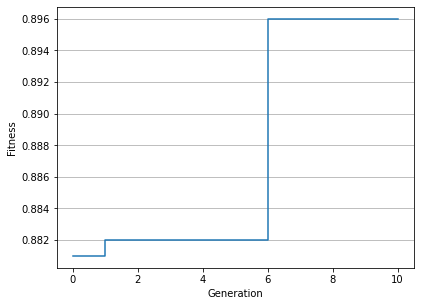

In [ ]:
gp_composer.history.show()

## Сравнение операторов

Одной из ключевых идей работы генетических алгоритмов является использование операторов **мутации**, **селекции** и **кроссовера**. При помощи правильно подобранных операций можно ускорить процесс схождения функции к оптимуму.

Далее мы наглядно убедимся в этом. В примерах выше, были использованы все возможные операторы. Теперь попробуем запустить алгоритм используя только конкретные и посмотрим на их влияния на процесс оптимизации.

Перед этим объявим несколько вспомогательных функций. Функция `launch_experiment` запускает процесс поиска для конкретной операции, она очень похожа на то, что было выполненно выше. В ней мы также задаем необходимые 

In [ ]:
def launch_experiment(train_data,
                      test_data,
                      mutation_types,
                      crossover_types,
                      timeout: None,
                      num_generations: int = 20,
                      visualize: bool = False):
    
    # Задаем задачу
    task = Task(TaskTypesEnum.classification)
    # Определяем операции, которые входят в пайплайн для этой задачи
    ops = get_operations_for_task(task)
    
    # Устанавливаем необходимые параметры для композера
    requirements = PipelineComposerRequirements(
        primary=ops,
        secondary=ops,
        num_of_generations=num_generations,
        timeout=timedelta(minutes=timeout) if timeout else None,
        early_stopping_iterations=None,
        n_jobs=-1,
    )
    
    # Задаем параметры для алгоритма
    gp_params = GPAlgorithmParameters(
        genetic_scheme_type=GeneticSchemeTypesEnum.generational,
        mutation_types=mutation_types,
        crossover_types=crossover_types,
    )

    # Задаем начальное приближение
    init_pipeline = PipelineBuilder().add_node('dt').build()

    # Объявляем композер и задаем ему параметры
    composer = ComposerBuilder(
        task=Task(TaskTypesEnum.classification)). \
        with_metrics(ClassificationMetricsEnum.ROCAUC). \
        with_requirements(requirements). \
        with_optimizer_params(gp_params). \
        with_initial_pipelines(init_pipeline). \
        build()

    # Запускаем поиск оптимального пайплайна
    pipeline = composer.compose_pipeline(train_data)
    pipeline.fit_from_scratch(train_data)

    # Делаем прогноз на отложенных данных
    predicted = pipeline.predict(test_data)

    # Подсчитываем метрику
    roc_auc_metric = roc_auc(y_true=test_data.target, y_score=predicted.predict)
    print('roc_auc=', roc_auc_metric)

    if visualize:
        pipeline.show()
        composer.history.show.fitness_line()

    return composer.history

Далее вспомогательные функции для загрузки и отрисовки истории

In [ ]:
def load_histories(history_dir, filename_filter=None):
    hs = []
    for obj in os.listdir(history_dir):
        fullpath = f'{history_dir}/{obj}'
        if not os.path.isfile(fullpath):
            continue
        if filename_filter and filename_filter not in str(obj):
            continue
        history = OptHistory.load(fullpath)
        hs.append(history)
    return hs

In [ ]:
def visualize_histories(histories: Sequence[OptHistory],
                        labels: Sequence[str],
                        with_confidence_interval: bool = True):
  
  color_pallete = cycle(px.colors.qualitative.Plotly)
  
  fig = go.Figure()
  
  best_num = 5

  for history, label in zip(histories, labels):
    h = history.historical_fitness # [1:-1]  # without initial and last pop
    best_fitness = np.abs(np.array([np.min(pop) for pop in h]))

    line_color = next(color_pallete)

    ys = best_fitness
    xs = np.arange(0, len(best_fitness))

    # График фитнесса
    fig.add_trace(go.Scatter(
        name=f'{label}', x=xs, y=ys,
        mode='lines', line=dict(color=line_color))
    )

    # Графики доверительного интервала
    if with_confidence_interval:
      best_num = min(len(xs), best_num)
      std_fitness = np.array([np.std(sorted(pop)[:best_num]) for pop in h])
      y_upper = ys + std_fitness
      y_lower = ys - std_fitness

      fig.add_trace(
          go.Scatter(
              name=f'{label} conf interval',
              x=xs.tolist() + xs[::-1].tolist(),
              y=y_upper.tolist() + y_lower[::-1].tolist(),
              fill='toself',
              fillcolor=line_color,
              line=dict(color='rgba(255,255,255,0)'),
              opacity=0.15,
              showlegend=False,
              hoverinfo='skip'
          )
      ) 

  fig.update_layout(
      xaxis_title='Generation',
      yaxis_title='Fitness',
      width=1200,
      height=600,
  )

  fig.show()

Для экспериментов выберем несколько **мутаций** и **кроссоверов**. Посмотрим на каждую из операций по отедльности и вкупе:

In [ ]:
all_mutations = [MutationTypesEnum.simple, MutationTypesEnum.growth, MutationTypesEnum.reduce]

mutation_types = [
    [MutationTypesEnum.simple],
    [MutationTypesEnum.growth],
    [MutationTypesEnum.reduce],
    all_mutations,
]

In [ ]:
all_crossovers = [CrossoverTypesEnum.one_point, CrossoverTypesEnum.subtree]

crossover_types = [
    [CrossoverTypesEnum.one_point],
    [CrossoverTypesEnum.subtree],
    all_crossovers,
]

Укажем место для сохранения истории, времени на каждый запуск и количество генераций

In [ ]:
save_dir = './'
timeout_per_run = None
num_generations = 20

In [ ]:
mutation_labels = ['Mutation simple', 'Mutation growth', 'Mutation reduce', 'Mutation all']

mutation_histories = []

for label, mutations in zip(mutation_labels, mutation_types):
    label = label.lower().replace(' ', '_')
    history_file_path = f'{save_dir}/{label}.json'

    history = launch_experiment(train_data, test_data,
                          timeout=timeout_per_run,
                          num_generations=num_generations,
                          mutation_types=mutations,
                          crossover_types=all_crossovers)
    mutation_histories.append(history)
    print(f'history is saved to path {history_file_path}')
    history.save(history_file_path)

INFO:root:DataSourceSplitter - Hold out validation is applied.


2023-03-16 13:25:05,514 - DataSourceSplitter - Hold out validation is applied.


Generations:   5%|▌         | 1/20 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:05,549 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


2023-03-16 13:25:14,314 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 1 size: 1


2023-03-16 13:25:14,325 - EvoGraphOptimizer - Generation num: 1 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.653 node_number=0.100>']


2023-03-16 13:25:14,333 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.653 node_number=0.100>']


2023-03-16 13:25:21,682 - EvoGraphOptimizer - Exceeded max number of attempts for extending initial graphs, stopping.Current size 1 instead of 20 graphs.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:21,689 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:25:30,863 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 2 size: 8


2023-03-16 13:25:30,886 - EvoGraphOptimizer - Generation num: 2 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:25:30,895 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:25:30,903 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:31,061 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:25:32,938 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 3 size: 8


2023-03-16 13:25:32,951 - EvoGraphOptimizer - Generation num: 3 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:25:32,955 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 13:25:32,959 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2023-03-16 13:25:32,962 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:25:32,964 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:33,067 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:25:34,949 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 4 size: 8


2023-03-16 13:25:34,962 - EvoGraphOptimizer - Generation num: 4 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:25:34,967 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-16 13:25:34,975 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2023-03-16 13:25:34,982 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:25:34,985 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:35,089 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:25:36,663 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 5 size: 8


2023-03-16 13:25:36,677 - EvoGraphOptimizer - Generation num: 5 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:25:36,683 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-03-16 13:25:36,688 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2023-03-16 13:25:36,691 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:25:36,694 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:36,798 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:25:38,442 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 6 size: 8


2023-03-16 13:25:38,456 - EvoGraphOptimizer - Generation num: 6 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:25:38,460 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 4 iterations


2023-03-16 13:25:38,464 - EvoGraphOptimizer - no improvements for 4 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2023-03-16 13:25:38,467 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:25:38,469 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:38,590 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:25:40,133 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 7 size: 8


2023-03-16 13:25:40,146 - EvoGraphOptimizer - Generation num: 7 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:25:40,151 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 5 iterations


2023-03-16 13:25:40,158 - EvoGraphOptimizer - no improvements for 5 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.6 min


2023-03-16 13:25:40,162 - EvoGraphOptimizer - spent time: 0.6 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:25:40,165 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:40,279 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:25:42,874 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 8 size: 8


2023-03-16 13:25:42,887 - EvoGraphOptimizer - Generation num: 8 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:25:42,891 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 6 iterations


2023-03-16 13:25:42,895 - EvoGraphOptimizer - no improvements for 6 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.6 min


2023-03-16 13:25:42,898 - EvoGraphOptimizer - spent time: 0.6 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:25:42,900 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:43,106 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:25:45,578 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 9 size: 8


2023-03-16 13:25:45,593 - EvoGraphOptimizer - Generation num: 9 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:25:45,598 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 7 iterations


2023-03-16 13:25:45,603 - EvoGraphOptimizer - no improvements for 7 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.7 min


2023-03-16 13:25:45,608 - EvoGraphOptimizer - spent time: 0.7 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:25:45,611 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:45,724 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:25:47,596 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 10 size: 8


2023-03-16 13:25:47,608 - EvoGraphOptimizer - Generation num: 10 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:25:47,613 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 8 iterations


2023-03-16 13:25:47,618 - EvoGraphOptimizer - no improvements for 8 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.7 min


2023-03-16 13:25:47,621 - EvoGraphOptimizer - spent time: 0.7 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:25:47,625 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:47,733 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:25:49,734 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 11 size: 8


2023-03-16 13:25:49,749 - EvoGraphOptimizer - Generation num: 11 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:25:49,754 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 9 iterations


2023-03-16 13:25:49,765 - EvoGraphOptimizer - no improvements for 9 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.7 min


2023-03-16 13:25:49,769 - EvoGraphOptimizer - spent time: 0.7 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:25:49,771 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:49,878 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:25:51,458 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 12 size: 8


2023-03-16 13:25:51,470 - EvoGraphOptimizer - Generation num: 12 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:25:51,474 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 10 iterations


2023-03-16 13:25:51,478 - EvoGraphOptimizer - no improvements for 10 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.8 min


2023-03-16 13:25:51,482 - EvoGraphOptimizer - spent time: 0.8 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:25:51,485 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:51,587 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:25:53,227 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 13 size: 8


2023-03-16 13:25:53,240 - EvoGraphOptimizer - Generation num: 13 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:25:53,244 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 11 iterations


2023-03-16 13:25:53,248 - EvoGraphOptimizer - no improvements for 11 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.8 min


2023-03-16 13:25:53,252 - EvoGraphOptimizer - spent time: 0.8 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:25:53,254 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:53,363 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:25:55,620 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 14 size: 8


2023-03-16 13:25:55,642 - EvoGraphOptimizer - Generation num: 14 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:25:55,650 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 12 iterations


2023-03-16 13:25:55,656 - EvoGraphOptimizer - no improvements for 12 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.8 min


2023-03-16 13:25:55,663 - EvoGraphOptimizer - spent time: 0.8 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:25:55,668 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:55,880 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:25:58,542 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 15 size: 8


2023-03-16 13:25:58,560 - EvoGraphOptimizer - Generation num: 15 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:25:58,566 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 13 iterations


2023-03-16 13:25:58,570 - EvoGraphOptimizer - no improvements for 13 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.9 min


2023-03-16 13:25:58,572 - EvoGraphOptimizer - spent time: 0.9 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:25:58,575 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:25:58,722 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:26:00,448 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 16 size: 8


2023-03-16 13:26:00,462 - EvoGraphOptimizer - Generation num: 16 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:26:00,467 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 14 iterations


2023-03-16 13:26:00,472 - EvoGraphOptimizer - no improvements for 14 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.9 min


2023-03-16 13:26:00,475 - EvoGraphOptimizer - spent time: 0.9 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:26:00,478 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:26:00,605 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:26:02,511 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 17 size: 8


2023-03-16 13:26:02,526 - EvoGraphOptimizer - Generation num: 17 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:26:02,532 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 15 iterations


2023-03-16 13:26:02,536 - EvoGraphOptimizer - no improvements for 15 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.0 min


2023-03-16 13:26:02,539 - EvoGraphOptimizer - spent time: 1.0 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:26:02,542 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:26:02,649 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:26:04,195 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 18 size: 8


2023-03-16 13:26:04,209 - EvoGraphOptimizer - Generation num: 18 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:26:04,213 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 16 iterations


2023-03-16 13:26:04,218 - EvoGraphOptimizer - no improvements for 16 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.0 min


2023-03-16 13:26:04,220 - EvoGraphOptimizer - spent time: 1.0 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:26:04,222 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:26:04,353 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:26:06,172 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 19 size: 8


2023-03-16 13:26:06,186 - EvoGraphOptimizer - Generation num: 19 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:26:06,190 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 17 iterations


2023-03-16 13:26:06,194 - EvoGraphOptimizer - no improvements for 17 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.0 min


2023-03-16 13:26:06,199 - EvoGraphOptimizer - spent time: 1.0 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:26:06,202 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:26:06,296 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:26:08,049 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 20 size: 8


2023-03-16 13:26:08,065 - EvoGraphOptimizer - Generation num: 20 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:26:08,069 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 18 iterations


2023-03-16 13:26:08,074 - EvoGraphOptimizer - no improvements for 18 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.0 min


2023-03-16 13:26:08,077 - EvoGraphOptimizer - spent time: 1.0 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:26:08,079 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:26:08,202 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


2023-03-16 13:26:10,223 - MultiprocessingDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 21 size: 8


2023-03-16 13:26:10,247 - EvoGraphOptimizer - Generation num: 21 size: 8


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:26:10,254 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 19 iterations


2023-03-16 13:26:10,263 - EvoGraphOptimizer - no improvements for 19 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.1 min


2023-03-16 13:26:10,271 - EvoGraphOptimizer - spent time: 1.1 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Max number of generations reached


2023-03-16 13:26:10,273 - GroupedCondition - Optimisation stopped: Max number of generations reached


Generations:   5%|▌         | 1/20 [01:04<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 1.079 min


2023-03-16 13:26:10,279 - OptimisationTimer - Composition time: 1.079 min


INFO:root:EvoGraphOptimizer - Generation num: 22 size: 1


2023-03-16 13:26:10,283 - EvoGraphOptimizer - Generation num: 22 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


2023-03-16 13:26:10,288 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.914 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 20 iterations


2023-03-16 13:26:10,290 - EvoGraphOptimizer - no improvements for 20 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.1 min


2023-03-16 13:26:10,293 - EvoGraphOptimizer - spent time: 1.1 min


INFO:root:GPComposer - GP composition finished


2023-03-16 13:26:10,296 - GPComposer - GP composition finished
roc_auc= 0.7278085991678225
history is saved to path .//mutation_simple.json


INFO:root:DataSourceSplitter - Hold out validation is applied.


2023-03-16 13:26:10,594 - DataSourceSplitter - Hold out validation is applied.


Generations:   5%|▌         | 1/20 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:26:10,603 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


2023-03-16 13:26:10,960 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 1 size: 1


2023-03-16 13:26:10,969 - EvoGraphOptimizer - Generation num: 1 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.599 node_number=0.100>']


2023-03-16 13:26:10,972 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.599 node_number=0.100>']


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:26:12,138 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:26:19,216 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 2 size: 20


2023-03-16 13:26:19,244 - EvoGraphOptimizer - Generation num: 2 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.792 node_number=0.500>']


2023-03-16 13:26:19,250 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.792 node_number=0.500>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:26:19,258 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:26:19,962 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:26:28,873 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 3 size: 20


2023-03-16 13:26:28,903 - EvoGraphOptimizer - Generation num: 3 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.808 node_number=0.500>']


2023-03-16 13:26:28,907 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.808 node_number=0.500>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:26:28,915 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:26:29,567 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:26:36,517 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 4 size: 20


2023-03-16 13:26:36,549 - EvoGraphOptimizer - Generation num: 4 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.825 node_number=0.600>']


2023-03-16 13:26:36,553 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.825 node_number=0.600>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:26:36,558 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:26:37,287 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:26:47,565 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 5 size: 20


2023-03-16 13:26:47,600 - EvoGraphOptimizer - Generation num: 5 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.871 node_number=0.500>']


2023-03-16 13:26:47,606 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.871 node_number=0.500>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:26:47,610 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:26:48,275 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:26:58,635 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 6 size: 20


2023-03-16 13:26:58,667 - EvoGraphOptimizer - Generation num: 6 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


2023-03-16 13:26:58,672 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:26:58,679 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:26:59,432 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:27:09,968 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 7 size: 20


2023-03-16 13:27:10,008 - EvoGraphOptimizer - Generation num: 7 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


2023-03-16 13:27:10,016 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 13:27:10,021 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.0 min


2023-03-16 13:27:10,025 - EvoGraphOptimizer - spent time: 1.0 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:27:10,027 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:27:11,097 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:27:20,234 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 8 size: 20


2023-03-16 13:27:20,264 - EvoGraphOptimizer - Generation num: 8 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


2023-03-16 13:27:20,267 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-16 13:27:20,273 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.2 min


2023-03-16 13:27:20,277 - EvoGraphOptimizer - spent time: 1.2 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:27:20,280 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:27:21,097 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:27:32,926 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 9 size: 20


2023-03-16 13:27:32,956 - EvoGraphOptimizer - Generation num: 9 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


2023-03-16 13:27:32,960 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-03-16 13:27:32,963 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.4 min


2023-03-16 13:27:32,965 - EvoGraphOptimizer - spent time: 1.4 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:27:32,968 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:27:33,757 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:27:45,090 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 10 size: 20


2023-03-16 13:27:45,121 - EvoGraphOptimizer - Generation num: 10 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


2023-03-16 13:27:45,125 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 4 iterations


2023-03-16 13:27:45,128 - EvoGraphOptimizer - no improvements for 4 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.6 min


2023-03-16 13:27:45,133 - EvoGraphOptimizer - spent time: 1.6 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:27:45,135 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:27:45,934 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:27:56,891 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 11 size: 20


2023-03-16 13:27:56,923 - EvoGraphOptimizer - Generation num: 11 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


2023-03-16 13:27:56,927 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 5 iterations


2023-03-16 13:27:56,931 - EvoGraphOptimizer - no improvements for 5 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.8 min


2023-03-16 13:27:56,934 - EvoGraphOptimizer - spent time: 1.8 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:27:56,937 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:27:57,517 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:28:06,734 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 12 size: 20


2023-03-16 13:28:06,793 - EvoGraphOptimizer - Generation num: 12 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


2023-03-16 13:28:06,803 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 6 iterations


2023-03-16 13:28:06,807 - EvoGraphOptimizer - no improvements for 6 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.9 min


2023-03-16 13:28:06,812 - EvoGraphOptimizer - spent time: 1.9 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:28:06,819 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:28:08,088 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:28:16,620 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 13 size: 20


2023-03-16 13:28:16,654 - EvoGraphOptimizer - Generation num: 13 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


2023-03-16 13:28:16,662 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 7 iterations


2023-03-16 13:28:16,669 - EvoGraphOptimizer - no improvements for 7 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.1 min


2023-03-16 13:28:16,674 - EvoGraphOptimizer - spent time: 2.1 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:28:16,679 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:28:17,395 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:28:28,016 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 14 size: 20


2023-03-16 13:28:28,051 - EvoGraphOptimizer - Generation num: 14 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


2023-03-16 13:28:28,055 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 8 iterations


2023-03-16 13:28:28,058 - EvoGraphOptimizer - no improvements for 8 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.3 min


2023-03-16 13:28:28,061 - EvoGraphOptimizer - spent time: 2.3 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:28:28,064 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:28:28,805 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:28:40,349 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 15 size: 20


2023-03-16 13:28:40,380 - EvoGraphOptimizer - Generation num: 15 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


2023-03-16 13:28:40,385 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 9 iterations


2023-03-16 13:28:40,390 - EvoGraphOptimizer - no improvements for 9 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.5 min


2023-03-16 13:28:40,393 - EvoGraphOptimizer - spent time: 2.5 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:28:40,401 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:28:41,212 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:28:53,459 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 16 size: 20


2023-03-16 13:28:53,491 - EvoGraphOptimizer - Generation num: 16 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


2023-03-16 13:28:53,495 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 10 iterations


2023-03-16 13:28:53,499 - EvoGraphOptimizer - no improvements for 10 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.7 min


2023-03-16 13:28:53,502 - EvoGraphOptimizer - spent time: 2.7 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:28:53,505 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:28:54,374 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:29:06,486 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 17 size: 20


2023-03-16 13:29:06,536 - EvoGraphOptimizer - Generation num: 17 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


2023-03-16 13:29:06,544 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 11 iterations


2023-03-16 13:29:06,548 - EvoGraphOptimizer - no improvements for 11 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.9 min


2023-03-16 13:29:06,552 - EvoGraphOptimizer - spent time: 2.9 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:29:06,556 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:29:07,502 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:29:18,905 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 18 size: 20


2023-03-16 13:29:18,964 - EvoGraphOptimizer - Generation num: 18 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


2023-03-16 13:29:18,971 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 12 iterations


2023-03-16 13:29:18,978 - EvoGraphOptimizer - no improvements for 12 iterations


INFO:root:EvoGraphOptimizer - spent time: 3.1 min


2023-03-16 13:29:18,985 - EvoGraphOptimizer - spent time: 3.1 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:29:18,988 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:29:20,285 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:29:31,241 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 19 size: 20


2023-03-16 13:29:31,274 - EvoGraphOptimizer - Generation num: 19 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


2023-03-16 13:29:31,279 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.910 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 13 iterations


2023-03-16 13:29:31,282 - EvoGraphOptimizer - no improvements for 13 iterations


INFO:root:EvoGraphOptimizer - spent time: 3.3 min


2023-03-16 13:29:31,285 - EvoGraphOptimizer - spent time: 3.3 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:29:31,287 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:29:32,577 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:29:43,355 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 20 size: 20


2023-03-16 13:29:43,386 - EvoGraphOptimizer - Generation num: 20 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.911 node_number=0.700>']


2023-03-16 13:29:43,390 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.911 node_number=0.700>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:29:43,394 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:29:44,092 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:29:54,390 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 21 size: 20


2023-03-16 13:29:54,420 - EvoGraphOptimizer - Generation num: 21 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.911 node_number=0.700>']


2023-03-16 13:29:54,424 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.911 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 13:29:54,428 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 3.7 min


2023-03-16 13:29:54,431 - EvoGraphOptimizer - spent time: 3.7 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Max number of generations reached


2023-03-16 13:29:54,434 - GroupedCondition - Optimisation stopped: Max number of generations reached


Generations:   5%|▌         | 1/20 [03:43<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 3.731 min


2023-03-16 13:29:54,438 - OptimisationTimer - Composition time: 3.731 min


INFO:root:EvoGraphOptimizer - Generation num: 22 size: 1


2023-03-16 13:29:54,442 - EvoGraphOptimizer - Generation num: 22 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.911 node_number=0.700>']


2023-03-16 13:29:54,445 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.911 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-16 13:29:54,447 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 3.7 min


2023-03-16 13:29:54,449 - EvoGraphOptimizer - spent time: 3.7 min


INFO:root:GPComposer - GP composition finished


2023-03-16 13:29:54,454 - GPComposer - GP composition finished
roc_auc= 0.6735436893203883
history is saved to path .//mutation_growth.json


INFO:root:DataSourceSplitter - Hold out validation is applied.


2023-03-16 13:29:55,890 - DataSourceSplitter - Hold out validation is applied.


Generations:   5%|▌         | 1/20 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:29:55,901 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


2023-03-16 13:29:56,179 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 1 size: 1


2023-03-16 13:29:56,188 - EvoGraphOptimizer - Generation num: 1 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:29:56,190 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:30:04,182 - EvoGraphOptimizer - Exceeded max number of attempts for extending initial graphs, stopping.Current size 1 instead of 20 graphs.


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:30:04,187 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


2023-03-16 13:30:04,194 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 2 size: 1


2023-03-16 13:30:04,199 - EvoGraphOptimizer - Generation num: 2 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:30:04,201 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 13:30:04,204 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.1 min


2023-03-16 13:30:04,207 - EvoGraphOptimizer - spent time: 0.1 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:30:04,210 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:30:04,597 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:30:10,401 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 3 size: 30


2023-03-16 13:30:10,435 - EvoGraphOptimizer - Generation num: 3 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:30:10,440 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-16 13:30:10,448 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.2 min


2023-03-16 13:30:10,455 - EvoGraphOptimizer - spent time: 0.2 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:30:10,458 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:30:10,838 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:30:17,450 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 4 size: 30


2023-03-16 13:30:17,489 - EvoGraphOptimizer - Generation num: 4 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:30:17,494 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-03-16 13:30:17,498 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.4 min


2023-03-16 13:30:17,502 - EvoGraphOptimizer - spent time: 0.4 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:30:17,504 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:30:18,203 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:30:24,403 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 5 size: 30


2023-03-16 13:30:24,437 - EvoGraphOptimizer - Generation num: 5 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:30:24,441 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 4 iterations


2023-03-16 13:30:24,446 - EvoGraphOptimizer - no improvements for 4 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2023-03-16 13:30:24,450 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:30:24,458 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:30:24,897 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:30:31,042 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 6 size: 30


2023-03-16 13:30:31,092 - EvoGraphOptimizer - Generation num: 6 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:30:31,096 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 5 iterations


2023-03-16 13:30:31,100 - EvoGraphOptimizer - no improvements for 5 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.6 min


2023-03-16 13:30:31,110 - EvoGraphOptimizer - spent time: 0.6 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:30:31,119 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:30:31,775 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:30:38,469 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 7 size: 30


2023-03-16 13:30:38,503 - EvoGraphOptimizer - Generation num: 7 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:30:38,508 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 6 iterations


2023-03-16 13:30:38,513 - EvoGraphOptimizer - no improvements for 6 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.7 min


2023-03-16 13:30:38,515 - EvoGraphOptimizer - spent time: 0.7 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:30:38,518 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:30:38,924 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:30:44,760 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 8 size: 30


2023-03-16 13:30:44,825 - EvoGraphOptimizer - Generation num: 8 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:30:44,832 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 7 iterations


2023-03-16 13:30:44,839 - EvoGraphOptimizer - no improvements for 7 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.8 min


2023-03-16 13:30:44,842 - EvoGraphOptimizer - spent time: 0.8 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:30:44,848 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:30:45,483 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:30:52,518 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 9 size: 30


2023-03-16 13:30:52,551 - EvoGraphOptimizer - Generation num: 9 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:30:52,555 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 8 iterations


2023-03-16 13:30:52,558 - EvoGraphOptimizer - no improvements for 8 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.9 min


2023-03-16 13:30:52,562 - EvoGraphOptimizer - spent time: 0.9 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:30:52,566 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:30:52,945 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:30:58,537 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 10 size: 30


2023-03-16 13:30:58,568 - EvoGraphOptimizer - Generation num: 10 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:30:58,574 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 9 iterations


2023-03-16 13:30:58,581 - EvoGraphOptimizer - no improvements for 9 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.0 min


2023-03-16 13:30:58,587 - EvoGraphOptimizer - spent time: 1.0 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:30:58,592 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:30:59,149 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:31:06,478 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 11 size: 30


2023-03-16 13:31:06,506 - EvoGraphOptimizer - Generation num: 11 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:31:06,510 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 10 iterations


2023-03-16 13:31:06,514 - EvoGraphOptimizer - no improvements for 10 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.2 min


2023-03-16 13:31:06,519 - EvoGraphOptimizer - spent time: 1.2 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:31:06,522 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:31:06,906 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:31:12,524 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 12 size: 30


2023-03-16 13:31:12,557 - EvoGraphOptimizer - Generation num: 12 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:31:12,566 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 11 iterations


2023-03-16 13:31:12,572 - EvoGraphOptimizer - no improvements for 11 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.3 min


2023-03-16 13:31:12,580 - EvoGraphOptimizer - spent time: 1.3 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:31:12,584 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:31:13,019 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:31:20,525 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 13 size: 30


2023-03-16 13:31:20,558 - EvoGraphOptimizer - Generation num: 13 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:31:20,562 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 12 iterations


2023-03-16 13:31:20,569 - EvoGraphOptimizer - no improvements for 12 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.4 min


2023-03-16 13:31:20,572 - EvoGraphOptimizer - spent time: 1.4 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:31:20,576 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:31:20,983 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:31:26,587 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 14 size: 30


2023-03-16 13:31:26,623 - EvoGraphOptimizer - Generation num: 14 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:31:26,627 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 13 iterations


2023-03-16 13:31:26,632 - EvoGraphOptimizer - no improvements for 13 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.5 min


2023-03-16 13:31:26,635 - EvoGraphOptimizer - spent time: 1.5 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:31:26,637 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:31:27,113 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:31:34,528 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 15 size: 30


2023-03-16 13:31:34,558 - EvoGraphOptimizer - Generation num: 15 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:31:34,562 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 14 iterations


2023-03-16 13:31:34,567 - EvoGraphOptimizer - no improvements for 14 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.6 min


2023-03-16 13:31:34,571 - EvoGraphOptimizer - spent time: 1.6 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:31:34,573 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:31:34,987 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:31:40,612 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 16 size: 30


2023-03-16 13:31:40,643 - EvoGraphOptimizer - Generation num: 16 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:31:40,647 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 15 iterations


2023-03-16 13:31:40,651 - EvoGraphOptimizer - no improvements for 15 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.7 min


2023-03-16 13:31:40,654 - EvoGraphOptimizer - spent time: 1.7 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:31:40,657 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:31:41,047 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:31:48,585 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 17 size: 30


2023-03-16 13:31:48,617 - EvoGraphOptimizer - Generation num: 17 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:31:48,621 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 16 iterations


2023-03-16 13:31:48,631 - EvoGraphOptimizer - no improvements for 16 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.9 min


2023-03-16 13:31:48,635 - EvoGraphOptimizer - spent time: 1.9 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:31:48,637 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:31:49,030 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:31:54,709 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 18 size: 30


2023-03-16 13:31:54,741 - EvoGraphOptimizer - Generation num: 18 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:31:54,745 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 17 iterations


2023-03-16 13:31:54,749 - EvoGraphOptimizer - no improvements for 17 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.0 min


2023-03-16 13:31:54,753 - EvoGraphOptimizer - spent time: 2.0 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:31:54,755 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:31:55,106 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:32:02,561 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 19 size: 30


2023-03-16 13:32:02,591 - EvoGraphOptimizer - Generation num: 19 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:32:02,596 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 18 iterations


2023-03-16 13:32:02,600 - EvoGraphOptimizer - no improvements for 18 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.1 min


2023-03-16 13:32:02,604 - EvoGraphOptimizer - spent time: 2.1 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:32:02,609 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:32:03,001 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:32:08,676 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 20 size: 30


2023-03-16 13:32:08,708 - EvoGraphOptimizer - Generation num: 20 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:32:08,712 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 19 iterations


2023-03-16 13:32:08,716 - EvoGraphOptimizer - no improvements for 19 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.2 min


2023-03-16 13:32:08,720 - EvoGraphOptimizer - spent time: 2.2 min


INFO:root:EvoGraphOptimizer - Next population size: 45; max graph depth: 3


2023-03-16 13:32:08,723 - EvoGraphOptimizer - Next population size: 45; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:32:09,109 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


2023-03-16 13:32:16,538 - MultiprocessingDispatcher - 30 individuals out of 30 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 21 size: 30


2023-03-16 13:32:16,571 - EvoGraphOptimizer - Generation num: 21 size: 30


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:32:16,574 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 20 iterations


2023-03-16 13:32:16,578 - EvoGraphOptimizer - no improvements for 20 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.3 min


2023-03-16 13:32:16,582 - EvoGraphOptimizer - spent time: 2.3 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Max number of generations reached


2023-03-16 13:32:16,585 - GroupedCondition - Optimisation stopped: Max number of generations reached


Generations:   5%|▌         | 1/20 [02:20<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 2.345 min


2023-03-16 13:32:16,588 - OptimisationTimer - Composition time: 2.345 min


INFO:root:EvoGraphOptimizer - Generation num: 22 size: 1


2023-03-16 13:32:16,591 - EvoGraphOptimizer - Generation num: 22 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


2023-03-16 13:32:16,594 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.661 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 21 iterations


2023-03-16 13:32:16,596 - EvoGraphOptimizer - no improvements for 21 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.3 min


2023-03-16 13:32:16,598 - EvoGraphOptimizer - spent time: 2.3 min


INFO:root:GPComposer - GP composition finished


2023-03-16 13:32:16,601 - GPComposer - GP composition finished
roc_auc= 0.6407766990291262
history is saved to path .//mutation_reduce.json


INFO:root:DataSourceSplitter - Hold out validation is applied.


2023-03-16 13:32:16,987 - DataSourceSplitter - Hold out validation is applied.


Generations:   5%|▌         | 1/20 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:32:16,995 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


2023-03-16 13:32:17,282 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 1 size: 1


2023-03-16 13:32:17,288 - EvoGraphOptimizer - Generation num: 1 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.737 node_number=0.100>']


2023-03-16 13:32:17,292 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.737 node_number=0.100>']


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:32:18,072 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:32:23,775 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 2 size: 20


2023-03-16 13:32:23,813 - EvoGraphOptimizer - Generation num: 2 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


2023-03-16 13:32:23,817 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:32:23,824 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:32:24,519 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:32:32,265 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 3 size: 20


2023-03-16 13:32:32,292 - EvoGraphOptimizer - Generation num: 3 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


2023-03-16 13:32:32,296 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 13:32:32,301 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.3 min


2023-03-16 13:32:32,306 - EvoGraphOptimizer - spent time: 0.3 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:32:32,310 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:32:32,826 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:32:39,328 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 4 size: 20


2023-03-16 13:32:39,367 - EvoGraphOptimizer - Generation num: 4 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


2023-03-16 13:32:39,371 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-16 13:32:39,379 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.4 min


2023-03-16 13:32:39,382 - EvoGraphOptimizer - spent time: 0.4 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:32:39,388 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:32:40,200 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:32:47,291 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 5 size: 20


2023-03-16 13:32:47,321 - EvoGraphOptimizer - Generation num: 5 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


2023-03-16 13:32:47,331 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-03-16 13:32:47,336 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2023-03-16 13:32:47,341 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:32:47,348 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:32:48,059 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:32:56,118 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 6 size: 20


2023-03-16 13:32:56,156 - EvoGraphOptimizer - Generation num: 6 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


2023-03-16 13:32:56,161 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 4 iterations


2023-03-16 13:32:56,167 - EvoGraphOptimizer - no improvements for 4 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.7 min


2023-03-16 13:32:56,170 - EvoGraphOptimizer - spent time: 0.7 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:32:56,172 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:32:57,122 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:33:04,096 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 7 size: 20


2023-03-16 13:33:04,123 - EvoGraphOptimizer - Generation num: 7 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


2023-03-16 13:33:04,127 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 5 iterations


2023-03-16 13:33:04,132 - EvoGraphOptimizer - no improvements for 5 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.8 min


2023-03-16 13:33:04,136 - EvoGraphOptimizer - spent time: 0.8 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:33:04,138 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:33:04,579 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:33:12,247 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 8 size: 20


2023-03-16 13:33:12,279 - EvoGraphOptimizer - Generation num: 8 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


2023-03-16 13:33:12,285 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 6 iterations


2023-03-16 13:33:12,289 - EvoGraphOptimizer - no improvements for 6 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.9 min


2023-03-16 13:33:12,293 - EvoGraphOptimizer - spent time: 0.9 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:33:12,297 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:33:12,805 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:33:18,327 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 9 size: 20


2023-03-16 13:33:18,358 - EvoGraphOptimizer - Generation num: 9 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


2023-03-16 13:33:18,366 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 7 iterations


2023-03-16 13:33:18,372 - EvoGraphOptimizer - no improvements for 7 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.0 min


2023-03-16 13:33:18,379 - EvoGraphOptimizer - spent time: 1.0 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:33:18,383 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:33:18,877 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:33:27,168 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 10 size: 20


2023-03-16 13:33:27,199 - EvoGraphOptimizer - Generation num: 10 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


2023-03-16 13:33:27,204 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 8 iterations


2023-03-16 13:33:27,208 - EvoGraphOptimizer - no improvements for 8 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.2 min


2023-03-16 13:33:27,211 - EvoGraphOptimizer - spent time: 1.2 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:33:27,214 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:33:27,775 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:33:34,677 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 11 size: 20


2023-03-16 13:33:34,703 - EvoGraphOptimizer - Generation num: 11 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


2023-03-16 13:33:34,707 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 9 iterations


2023-03-16 13:33:34,715 - EvoGraphOptimizer - no improvements for 9 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.3 min


2023-03-16 13:33:34,727 - EvoGraphOptimizer - spent time: 1.3 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:33:34,733 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:33:35,370 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:33:44,408 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 12 size: 20


2023-03-16 13:33:44,441 - EvoGraphOptimizer - Generation num: 12 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


2023-03-16 13:33:44,444 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 10 iterations


2023-03-16 13:33:44,449 - EvoGraphOptimizer - no improvements for 10 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.5 min


2023-03-16 13:33:44,452 - EvoGraphOptimizer - spent time: 1.5 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:33:44,455 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:33:45,090 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:33:52,925 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 13 size: 20


2023-03-16 13:33:52,962 - EvoGraphOptimizer - Generation num: 13 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


2023-03-16 13:33:52,971 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 11 iterations


2023-03-16 13:33:52,974 - EvoGraphOptimizer - no improvements for 11 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.6 min


2023-03-16 13:33:52,979 - EvoGraphOptimizer - spent time: 1.6 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:33:52,984 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:33:53,784 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:34:00,515 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 14 size: 20


2023-03-16 13:34:00,541 - EvoGraphOptimizer - Generation num: 14 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


2023-03-16 13:34:00,546 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:34:00,550 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:34:01,075 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:34:10,319 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 15 size: 20


2023-03-16 13:34:10,350 - EvoGraphOptimizer - Generation num: 15 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


2023-03-16 13:34:10,356 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 13:34:10,364 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.9 min


2023-03-16 13:34:10,372 - EvoGraphOptimizer - spent time: 1.9 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:34:10,375 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:34:10,955 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:34:18,448 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 16 size: 20


2023-03-16 13:34:18,480 - EvoGraphOptimizer - Generation num: 16 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


2023-03-16 13:34:18,485 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-16 13:34:18,489 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.0 min


2023-03-16 13:34:18,493 - EvoGraphOptimizer - spent time: 2.0 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:34:18,495 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:34:19,266 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:34:28,244 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 17 size: 20


2023-03-16 13:34:28,277 - EvoGraphOptimizer - Generation num: 17 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


2023-03-16 13:34:28,287 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-03-16 13:34:28,290 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.2 min


2023-03-16 13:34:28,293 - EvoGraphOptimizer - spent time: 2.2 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:34:28,301 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:34:28,825 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:34:37,998 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 18 size: 20


2023-03-16 13:34:38,029 - EvoGraphOptimizer - Generation num: 18 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


2023-03-16 13:34:38,034 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


INFO:root:EvoGraphOptimizer - no improvements for 4 iterations


2023-03-16 13:34:38,038 - EvoGraphOptimizer - no improvements for 4 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.4 min


2023-03-16 13:34:38,043 - EvoGraphOptimizer - spent time: 2.4 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:34:38,052 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:34:38,624 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:34:45,069 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 19 size: 20


2023-03-16 13:34:45,103 - EvoGraphOptimizer - Generation num: 19 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


2023-03-16 13:34:45,108 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


INFO:root:EvoGraphOptimizer - no improvements for 5 iterations


2023-03-16 13:34:45,110 - EvoGraphOptimizer - no improvements for 5 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.5 min


2023-03-16 13:34:45,113 - EvoGraphOptimizer - spent time: 2.5 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:34:45,118 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:34:45,641 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:34:54,022 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 20 size: 20


2023-03-16 13:34:54,057 - EvoGraphOptimizer - Generation num: 20 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


2023-03-16 13:34:54,064 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


INFO:root:EvoGraphOptimizer - no improvements for 6 iterations


2023-03-16 13:34:54,073 - EvoGraphOptimizer - no improvements for 6 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.6 min


2023-03-16 13:34:54,078 - EvoGraphOptimizer - spent time: 2.6 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:34:54,083 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:34:54,660 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:35:00,831 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 21 size: 20


2023-03-16 13:35:00,858 - EvoGraphOptimizer - Generation num: 21 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


2023-03-16 13:35:00,862 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


INFO:root:EvoGraphOptimizer - no improvements for 7 iterations


2023-03-16 13:35:00,866 - EvoGraphOptimizer - no improvements for 7 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.7 min


2023-03-16 13:35:00,870 - EvoGraphOptimizer - spent time: 2.7 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Max number of generations reached


2023-03-16 13:35:00,872 - GroupedCondition - Optimisation stopped: Max number of generations reached


Generations:   5%|▌         | 1/20 [02:43<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 2.732 min


2023-03-16 13:35:00,884 - OptimisationTimer - Composition time: 2.732 min


INFO:root:EvoGraphOptimizer - Generation num: 22 size: 1


2023-03-16 13:35:00,889 - EvoGraphOptimizer - Generation num: 22 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


2023-03-16 13:35:00,892 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.400>']


INFO:root:EvoGraphOptimizer - no improvements for 8 iterations


2023-03-16 13:35:00,894 - EvoGraphOptimizer - no improvements for 8 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.7 min


2023-03-16 13:35:00,900 - EvoGraphOptimizer - spent time: 2.7 min


INFO:root:GPComposer - GP composition finished


2023-03-16 13:35:00,903 - GPComposer - GP composition finished
roc_auc= 0.7501733703190014
history is saved to path .//mutation_all.json


In [ ]:
crossover_labels = ['Crossover one point', 'Crossover subtree', 'Crossover all']

crossover_histories = []

for label, crossover in zip(crossover_labels, crossover_types):
    label = label.lower().replace(' ', '_')
    history_file_path = f'{save_dir}/{label}.json'

    history = launch_experiment(train_data, test_data,
                          timeout=timeout_per_run,
                          mutation_types=all_mutations,
                          crossover_types=crossover)
    crossover_histories.append(history)
    print(f'history is saved to path {history_file_path}')
    history.save(history_file_path)

INFO:root:DataSourceSplitter - Hold out validation is applied.


2023-03-16 13:35:01,522 - DataSourceSplitter - Hold out validation is applied.


Generations:   5%|▌         | 1/20 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:35:01,531 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


2023-03-16 13:35:01,903 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 1 size: 1


2023-03-16 13:35:01,909 - EvoGraphOptimizer - Generation num: 1 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.735 node_number=0.100>']


2023-03-16 13:35:01,915 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.735 node_number=0.100>']


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:35:03,280 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:35:09,896 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 2 size: 20


2023-03-16 13:35:09,918 - EvoGraphOptimizer - Generation num: 2 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.892 node_number=0.100>']


2023-03-16 13:35:09,923 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.892 node_number=0.100>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:35:09,927 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:35:10,338 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:35:15,957 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 3 size: 20


2023-03-16 13:35:15,980 - EvoGraphOptimizer - Generation num: 3 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.892 node_number=0.100>']


2023-03-16 13:35:15,983 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.892 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 13:35:15,987 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.2 min


2023-03-16 13:35:15,990 - EvoGraphOptimizer - spent time: 0.2 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:35:15,993 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:35:16,645 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:35:24,649 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 4 size: 20


2023-03-16 13:35:24,673 - EvoGraphOptimizer - Generation num: 4 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.901 node_number=0.500>']


2023-03-16 13:35:24,678 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.901 node_number=0.500>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:35:24,682 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:35:25,142 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:35:32,169 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 5 size: 20


2023-03-16 13:35:32,203 - EvoGraphOptimizer - Generation num: 5 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.901 node_number=0.500>']


2023-03-16 13:35:32,209 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.901 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 13:35:32,213 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2023-03-16 13:35:32,218 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:35:32,222 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:35:33,035 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:35:40,715 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 6 size: 20


2023-03-16 13:35:40,746 - EvoGraphOptimizer - Generation num: 6 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.901 node_number=0.500>']


2023-03-16 13:35:40,751 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.901 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-16 13:35:40,756 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.7 min


2023-03-16 13:35:40,759 - EvoGraphOptimizer - spent time: 0.7 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:35:40,763 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:35:41,239 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:35:49,785 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 7 size: 20


2023-03-16 13:35:49,812 - EvoGraphOptimizer - Generation num: 7 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.500>']


2023-03-16 13:35:49,816 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.500>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:35:49,821 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:35:50,247 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:35:56,298 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 8 size: 20


2023-03-16 13:35:56,323 - EvoGraphOptimizer - Generation num: 8 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.500>']


2023-03-16 13:35:56,330 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.902 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 13:35:56,334 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.9 min


2023-03-16 13:35:56,339 - EvoGraphOptimizer - spent time: 0.9 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:35:56,345 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:35:56,744 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:36:05,206 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 9 size: 20


2023-03-16 13:36:05,231 - EvoGraphOptimizer - Generation num: 9 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


2023-03-16 13:36:05,235 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:36:05,239 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:36:05,788 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:36:12,335 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 10 size: 20


2023-03-16 13:36:12,362 - EvoGraphOptimizer - Generation num: 10 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


2023-03-16 13:36:12,366 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 13:36:12,371 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.2 min


2023-03-16 13:36:12,374 - EvoGraphOptimizer - spent time: 1.2 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:36:12,376 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:36:12,858 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:36:20,820 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 11 size: 20


2023-03-16 13:36:20,844 - EvoGraphOptimizer - Generation num: 11 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


2023-03-16 13:36:20,851 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-16 13:36:20,855 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.3 min


2023-03-16 13:36:20,860 - EvoGraphOptimizer - spent time: 1.3 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:36:20,863 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:36:21,389 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:36:27,844 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 12 size: 20


2023-03-16 13:36:27,869 - EvoGraphOptimizer - Generation num: 12 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


2023-03-16 13:36:27,876 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-03-16 13:36:27,886 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.4 min


2023-03-16 13:36:27,890 - EvoGraphOptimizer - spent time: 1.4 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:36:27,893 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:36:28,648 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:36:36,872 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 13 size: 20


2023-03-16 13:36:36,898 - EvoGraphOptimizer - Generation num: 13 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


2023-03-16 13:36:36,903 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 4 iterations


2023-03-16 13:36:36,907 - EvoGraphOptimizer - no improvements for 4 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.6 min


2023-03-16 13:36:36,911 - EvoGraphOptimizer - spent time: 1.6 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:36:36,914 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:36:37,361 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:36:44,906 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 14 size: 20


2023-03-16 13:36:44,940 - EvoGraphOptimizer - Generation num: 14 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


2023-03-16 13:36:44,948 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 5 iterations


2023-03-16 13:36:44,954 - EvoGraphOptimizer - no improvements for 5 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.7 min


2023-03-16 13:36:44,958 - EvoGraphOptimizer - spent time: 1.7 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:36:44,965 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:36:45,862 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:36:53,435 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 15 size: 20


2023-03-16 13:36:53,462 - EvoGraphOptimizer - Generation num: 15 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


2023-03-16 13:36:53,467 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 6 iterations


2023-03-16 13:36:53,471 - EvoGraphOptimizer - no improvements for 6 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.9 min


2023-03-16 13:36:53,477 - EvoGraphOptimizer - spent time: 1.9 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:36:53,479 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:36:54,063 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:37:03,607 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 16 size: 20


2023-03-16 13:37:03,637 - EvoGraphOptimizer - Generation num: 16 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


2023-03-16 13:37:03,641 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 7 iterations


2023-03-16 13:37:03,648 - EvoGraphOptimizer - no improvements for 7 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.0 min


2023-03-16 13:37:03,654 - EvoGraphOptimizer - spent time: 2.0 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:37:03,658 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:37:04,218 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:37:12,314 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 17 size: 20


2023-03-16 13:37:12,349 - EvoGraphOptimizer - Generation num: 17 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


2023-03-16 13:37:12,354 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 8 iterations


2023-03-16 13:37:12,358 - EvoGraphOptimizer - no improvements for 8 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.2 min


2023-03-16 13:37:12,361 - EvoGraphOptimizer - spent time: 2.2 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:37:12,364 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:37:13,806 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:37:22,554 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 18 size: 20


2023-03-16 13:37:22,581 - EvoGraphOptimizer - Generation num: 18 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


2023-03-16 13:37:22,585 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 9 iterations


2023-03-16 13:37:22,589 - EvoGraphOptimizer - no improvements for 9 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.4 min


2023-03-16 13:37:22,593 - EvoGraphOptimizer - spent time: 2.4 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:37:22,595 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:37:23,088 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:37:32,620 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 19 size: 20


2023-03-16 13:37:32,646 - EvoGraphOptimizer - Generation num: 19 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


2023-03-16 13:37:32,650 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 10 iterations


2023-03-16 13:37:32,655 - EvoGraphOptimizer - no improvements for 10 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.5 min


2023-03-16 13:37:32,658 - EvoGraphOptimizer - spent time: 2.5 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:37:32,662 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:37:33,246 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:37:41,384 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 20 size: 20


2023-03-16 13:37:41,422 - EvoGraphOptimizer - Generation num: 20 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


2023-03-16 13:37:41,427 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 11 iterations


2023-03-16 13:37:41,431 - EvoGraphOptimizer - no improvements for 11 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.7 min


2023-03-16 13:37:41,435 - EvoGraphOptimizer - spent time: 2.7 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:37:41,438 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:37:42,478 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:37:51,307 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 21 size: 20


2023-03-16 13:37:51,336 - EvoGraphOptimizer - Generation num: 21 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


2023-03-16 13:37:51,340 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 12 iterations


2023-03-16 13:37:51,344 - EvoGraphOptimizer - no improvements for 12 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.8 min


2023-03-16 13:37:51,348 - EvoGraphOptimizer - spent time: 2.8 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Max number of generations reached


2023-03-16 13:37:51,351 - GroupedCondition - Optimisation stopped: Max number of generations reached


Generations:   5%|▌         | 1/20 [02:49<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 2.83 min


2023-03-16 13:37:51,354 - OptimisationTimer - Composition time: 2.83 min


INFO:root:EvoGraphOptimizer - Generation num: 22 size: 1


2023-03-16 13:37:51,359 - EvoGraphOptimizer - Generation num: 22 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


2023-03-16 13:37:51,361 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.905 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 13 iterations


2023-03-16 13:37:51,363 - EvoGraphOptimizer - no improvements for 13 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.8 min


2023-03-16 13:37:51,365 - EvoGraphOptimizer - spent time: 2.8 min


INFO:root:GPComposer - GP composition finished


2023-03-16 13:37:51,370 - GPComposer - GP composition finished
roc_auc= 0.7432385575589459
history is saved to path .//crossover_one_point.json


INFO:root:DataSourceSplitter - Hold out validation is applied.


2023-03-16 13:37:51,994 - DataSourceSplitter - Hold out validation is applied.


Generations:   5%|▌         | 1/20 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:37:52,007 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


2023-03-16 13:37:52,301 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 1 size: 1


2023-03-16 13:37:52,309 - EvoGraphOptimizer - Generation num: 1 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.749 node_number=0.100>']


2023-03-16 13:37:52,316 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.749 node_number=0.100>']


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:37:53,011 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:37:59,908 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 2 size: 20


2023-03-16 13:37:59,933 - EvoGraphOptimizer - Generation num: 2 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:37:59,937 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:37:59,941 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:38:00,395 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:38:06,413 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 3 size: 20


2023-03-16 13:38:06,438 - EvoGraphOptimizer - Generation num: 3 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:38:06,442 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 13:38:06,446 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.2 min


2023-03-16 13:38:06,449 - EvoGraphOptimizer - spent time: 0.2 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:38:06,452 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:38:07,135 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:38:15,223 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 4 size: 20


2023-03-16 13:38:15,249 - EvoGraphOptimizer - Generation num: 4 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:38:15,253 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-16 13:38:15,257 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.4 min


2023-03-16 13:38:15,262 - EvoGraphOptimizer - spent time: 0.4 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:38:15,264 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:38:15,971 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:38:22,914 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 5 size: 20


2023-03-16 13:38:22,945 - EvoGraphOptimizer - Generation num: 5 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:38:22,950 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-03-16 13:38:22,953 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2023-03-16 13:38:22,955 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:38:22,958 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:38:23,433 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:38:32,385 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 6 size: 20


2023-03-16 13:38:32,418 - EvoGraphOptimizer - Generation num: 6 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:38:32,422 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 4 iterations


2023-03-16 13:38:32,427 - EvoGraphOptimizer - no improvements for 4 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.7 min


2023-03-16 13:38:32,432 - EvoGraphOptimizer - spent time: 0.7 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:38:32,435 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:38:32,926 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:38:39,004 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 7 size: 20


2023-03-16 13:38:39,049 - EvoGraphOptimizer - Generation num: 7 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:38:39,058 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 5 iterations


2023-03-16 13:38:39,066 - EvoGraphOptimizer - no improvements for 5 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.8 min


2023-03-16 13:38:39,072 - EvoGraphOptimizer - spent time: 0.8 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:38:39,076 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:38:39,913 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:38:47,973 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 8 size: 20


2023-03-16 13:38:48,000 - EvoGraphOptimizer - Generation num: 8 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:38:48,007 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 6 iterations


2023-03-16 13:38:48,017 - EvoGraphOptimizer - no improvements for 6 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.9 min


2023-03-16 13:38:48,024 - EvoGraphOptimizer - spent time: 0.9 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:38:48,031 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:38:48,483 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:38:57,479 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 9 size: 20


2023-03-16 13:38:57,506 - EvoGraphOptimizer - Generation num: 9 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:38:57,510 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 7 iterations


2023-03-16 13:38:57,514 - EvoGraphOptimizer - no improvements for 7 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.1 min


2023-03-16 13:38:57,518 - EvoGraphOptimizer - spent time: 1.1 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:38:57,526 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:38:57,967 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:39:04,226 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 10 size: 20


2023-03-16 13:39:04,250 - EvoGraphOptimizer - Generation num: 10 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:39:04,254 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 8 iterations


2023-03-16 13:39:04,258 - EvoGraphOptimizer - no improvements for 8 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.2 min


2023-03-16 13:39:04,263 - EvoGraphOptimizer - spent time: 1.2 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:39:04,265 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:39:04,858 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:39:12,865 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 11 size: 20


2023-03-16 13:39:12,894 - EvoGraphOptimizer - Generation num: 11 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:39:12,898 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 9 iterations


2023-03-16 13:39:12,905 - EvoGraphOptimizer - no improvements for 9 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.3 min


2023-03-16 13:39:12,912 - EvoGraphOptimizer - spent time: 1.3 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:39:12,915 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:39:13,521 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:39:19,657 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 12 size: 20


2023-03-16 13:39:19,688 - EvoGraphOptimizer - Generation num: 12 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:39:19,692 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 10 iterations


2023-03-16 13:39:19,697 - EvoGraphOptimizer - no improvements for 10 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.5 min


2023-03-16 13:39:19,700 - EvoGraphOptimizer - spent time: 1.5 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:39:19,702 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:39:20,497 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:39:28,620 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 13 size: 20


2023-03-16 13:39:28,648 - EvoGraphOptimizer - Generation num: 13 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:39:28,652 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 11 iterations


2023-03-16 13:39:28,656 - EvoGraphOptimizer - no improvements for 11 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.6 min


2023-03-16 13:39:28,663 - EvoGraphOptimizer - spent time: 1.6 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:39:28,666 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:39:29,439 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:39:37,404 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 14 size: 20


2023-03-16 13:39:37,435 - EvoGraphOptimizer - Generation num: 14 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:39:37,439 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 12 iterations


2023-03-16 13:39:37,444 - EvoGraphOptimizer - no improvements for 12 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.8 min


2023-03-16 13:39:37,446 - EvoGraphOptimizer - spent time: 1.8 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:39:37,449 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:39:38,350 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:39:46,641 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 15 size: 20


2023-03-16 13:39:46,671 - EvoGraphOptimizer - Generation num: 15 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:39:46,675 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 13 iterations


2023-03-16 13:39:46,680 - EvoGraphOptimizer - no improvements for 13 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.9 min


2023-03-16 13:39:46,684 - EvoGraphOptimizer - spent time: 1.9 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:39:46,687 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:39:47,184 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:39:56,821 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 16 size: 20


2023-03-16 13:39:56,848 - EvoGraphOptimizer - Generation num: 16 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:39:56,854 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 14 iterations


2023-03-16 13:39:56,857 - EvoGraphOptimizer - no improvements for 14 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.1 min


2023-03-16 13:39:56,862 - EvoGraphOptimizer - spent time: 2.1 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:39:56,864 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:39:57,352 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:40:05,240 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 17 size: 20


2023-03-16 13:40:05,273 - EvoGraphOptimizer - Generation num: 17 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:40:05,278 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 15 iterations


2023-03-16 13:40:05,284 - EvoGraphOptimizer - no improvements for 15 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.2 min


2023-03-16 13:40:05,291 - EvoGraphOptimizer - spent time: 2.2 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:40:05,295 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:40:06,404 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:40:14,517 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 18 size: 20


2023-03-16 13:40:14,544 - EvoGraphOptimizer - Generation num: 18 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:40:14,549 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 16 iterations


2023-03-16 13:40:14,553 - EvoGraphOptimizer - no improvements for 16 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.4 min


2023-03-16 13:40:14,556 - EvoGraphOptimizer - spent time: 2.4 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:40:14,560 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:40:15,008 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:40:23,223 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 19 size: 20


2023-03-16 13:40:23,252 - EvoGraphOptimizer - Generation num: 19 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:40:23,256 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 17 iterations


2023-03-16 13:40:23,260 - EvoGraphOptimizer - no improvements for 17 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.5 min


2023-03-16 13:40:23,264 - EvoGraphOptimizer - spent time: 2.5 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:40:23,266 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:40:23,782 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:40:30,959 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 20 size: 20


2023-03-16 13:40:30,985 - EvoGraphOptimizer - Generation num: 20 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:40:30,989 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 18 iterations


2023-03-16 13:40:30,993 - EvoGraphOptimizer - no improvements for 18 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.6 min


2023-03-16 13:40:30,997 - EvoGraphOptimizer - spent time: 2.6 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:40:31,000 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:40:31,559 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:40:39,645 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 21 size: 20


2023-03-16 13:40:39,674 - EvoGraphOptimizer - Generation num: 21 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:40:39,678 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 19 iterations


2023-03-16 13:40:39,686 - EvoGraphOptimizer - no improvements for 19 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.8 min


2023-03-16 13:40:39,690 - EvoGraphOptimizer - spent time: 2.8 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Max number of generations reached


2023-03-16 13:40:39,700 - GroupedCondition - Optimisation stopped: Max number of generations reached


Generations:   5%|▌         | 1/20 [02:47<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 2.795 min


2023-03-16 13:40:39,709 - OptimisationTimer - Composition time: 2.795 min


INFO:root:EvoGraphOptimizer - Generation num: 22 size: 1


2023-03-16 13:40:39,715 - EvoGraphOptimizer - Generation num: 22 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


2023-03-16 13:40:39,721 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.890 node_number=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 20 iterations


2023-03-16 13:40:39,727 - EvoGraphOptimizer - no improvements for 20 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.8 min


2023-03-16 13:40:39,731 - EvoGraphOptimizer - spent time: 2.8 min


INFO:root:GPComposer - GP composition finished


2023-03-16 13:40:39,738 - GPComposer - GP composition finished
roc_auc= 0.7278085991678225
history is saved to path .//crossover_subtree.json


INFO:root:DataSourceSplitter - Hold out validation is applied.


2023-03-16 13:40:40,188 - DataSourceSplitter - Hold out validation is applied.


Generations:   5%|▌         | 1/20 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:40:40,201 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


2023-03-16 13:40:40,487 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 1 size: 1


2023-03-16 13:40:40,492 - EvoGraphOptimizer - Generation num: 1 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.725 node_number=0.100>']


2023-03-16 13:40:40,495 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.725 node_number=0.100>']


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:40:41,218 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:40:46,377 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 2 size: 20


2023-03-16 13:40:46,407 - EvoGraphOptimizer - Generation num: 2 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.909 node_number=0.700>']


2023-03-16 13:40:46,412 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.909 node_number=0.700>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:40:46,416 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:40:46,845 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:40:54,531 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 3 size: 20


2023-03-16 13:40:54,559 - EvoGraphOptimizer - Generation num: 3 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.909 node_number=0.700>']


2023-03-16 13:40:54,562 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.909 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 13:40:54,566 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.2 min


2023-03-16 13:40:54,570 - EvoGraphOptimizer - spent time: 0.2 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:40:54,572 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:40:55,116 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:41:00,732 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 4 size: 20


2023-03-16 13:41:00,757 - EvoGraphOptimizer - Generation num: 4 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.909 node_number=0.700>']


2023-03-16 13:41:00,761 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.909 node_number=0.700>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-16 13:41:00,766 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.3 min


2023-03-16 13:41:00,771 - EvoGraphOptimizer - spent time: 0.3 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:41:00,779 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:41:01,276 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:41:08,920 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 5 size: 20


2023-03-16 13:41:08,951 - EvoGraphOptimizer - Generation num: 5 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


2023-03-16 13:41:08,959 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:41:08,963 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:41:09,432 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:41:15,445 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 6 size: 20


2023-03-16 13:41:15,474 - EvoGraphOptimizer - Generation num: 6 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


2023-03-16 13:41:15,481 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 13:41:15,487 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.6 min


2023-03-16 13:41:15,491 - EvoGraphOptimizer - spent time: 0.6 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:41:15,493 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:41:15,977 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:41:24,181 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 7 size: 20


2023-03-16 13:41:24,210 - EvoGraphOptimizer - Generation num: 7 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


2023-03-16 13:41:24,214 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-16 13:41:24,219 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.7 min


2023-03-16 13:41:24,222 - EvoGraphOptimizer - spent time: 0.7 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:41:24,225 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:41:24,878 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:41:32,530 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 8 size: 20


2023-03-16 13:41:32,562 - EvoGraphOptimizer - Generation num: 8 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


2023-03-16 13:41:32,566 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-03-16 13:41:32,571 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.9 min


2023-03-16 13:41:32,573 - EvoGraphOptimizer - spent time: 0.9 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:41:32,576 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:41:33,330 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:41:40,152 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 9 size: 20


2023-03-16 13:41:40,185 - EvoGraphOptimizer - Generation num: 9 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


2023-03-16 13:41:40,193 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 4 iterations


2023-03-16 13:41:40,197 - EvoGraphOptimizer - no improvements for 4 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.0 min


2023-03-16 13:41:40,202 - EvoGraphOptimizer - spent time: 1.0 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:41:40,205 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:41:40,796 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:41:49,790 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 10 size: 20


2023-03-16 13:41:49,824 - EvoGraphOptimizer - Generation num: 10 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


2023-03-16 13:41:49,826 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 5 iterations


2023-03-16 13:41:49,831 - EvoGraphOptimizer - no improvements for 5 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.2 min


2023-03-16 13:41:49,833 - EvoGraphOptimizer - spent time: 1.2 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:41:49,836 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:41:50,403 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:41:57,473 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 11 size: 20


2023-03-16 13:41:57,503 - EvoGraphOptimizer - Generation num: 11 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


2023-03-16 13:41:57,506 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 6 iterations


2023-03-16 13:41:57,513 - EvoGraphOptimizer - no improvements for 6 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.3 min


2023-03-16 13:41:57,516 - EvoGraphOptimizer - spent time: 1.3 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:41:57,519 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:41:57,997 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:42:06,805 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 12 size: 20


2023-03-16 13:42:06,834 - EvoGraphOptimizer - Generation num: 12 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


2023-03-16 13:42:06,838 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 7 iterations


2023-03-16 13:42:06,843 - EvoGraphOptimizer - no improvements for 7 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.4 min


2023-03-16 13:42:06,848 - EvoGraphOptimizer - spent time: 1.4 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:42:06,852 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:42:07,316 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:42:13,974 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 13 size: 20


2023-03-16 13:42:14,003 - EvoGraphOptimizer - Generation num: 13 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


2023-03-16 13:42:14,007 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.916 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 8 iterations


2023-03-16 13:42:14,013 - EvoGraphOptimizer - no improvements for 8 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.6 min


2023-03-16 13:42:14,016 - EvoGraphOptimizer - spent time: 1.6 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:42:14,022 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:42:14,813 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:42:23,828 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 14 size: 20


2023-03-16 13:42:23,858 - EvoGraphOptimizer - Generation num: 14 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


2023-03-16 13:42:23,861 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:42:23,865 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:42:24,356 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:42:33,442 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 15 size: 20


2023-03-16 13:42:33,472 - EvoGraphOptimizer - Generation num: 15 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


2023-03-16 13:42:33,476 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-16 13:42:33,480 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.9 min


2023-03-16 13:42:33,483 - EvoGraphOptimizer - spent time: 1.9 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:42:33,485 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:42:34,049 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:42:41,069 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 16 size: 20


2023-03-16 13:42:41,101 - EvoGraphOptimizer - Generation num: 16 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


2023-03-16 13:42:41,112 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-16 13:42:41,115 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.0 min


2023-03-16 13:42:41,119 - EvoGraphOptimizer - spent time: 2.0 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:42:41,122 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:42:41,666 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:42:51,411 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 17 size: 20


2023-03-16 13:42:51,442 - EvoGraphOptimizer - Generation num: 17 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


2023-03-16 13:42:51,446 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-03-16 13:42:51,450 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.2 min


2023-03-16 13:42:51,454 - EvoGraphOptimizer - spent time: 2.2 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:42:51,456 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:42:52,074 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:43:00,457 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 18 size: 20


2023-03-16 13:43:00,500 - EvoGraphOptimizer - Generation num: 18 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


2023-03-16 13:43:00,510 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 4 iterations


2023-03-16 13:43:00,518 - EvoGraphOptimizer - no improvements for 4 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.3 min


2023-03-16 13:43:00,521 - EvoGraphOptimizer - spent time: 2.3 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:43:00,527 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:43:01,470 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:43:09,534 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 19 size: 20


2023-03-16 13:43:09,571 - EvoGraphOptimizer - Generation num: 19 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


2023-03-16 13:43:09,575 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 5 iterations


2023-03-16 13:43:09,579 - EvoGraphOptimizer - no improvements for 5 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.5 min


2023-03-16 13:43:09,582 - EvoGraphOptimizer - spent time: 2.5 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:43:09,585 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:43:10,132 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:43:19,520 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 20 size: 20


2023-03-16 13:43:19,551 - EvoGraphOptimizer - Generation num: 20 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


2023-03-16 13:43:19,553 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 6 iterations


2023-03-16 13:43:19,560 - EvoGraphOptimizer - no improvements for 6 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.7 min


2023-03-16 13:43:19,565 - EvoGraphOptimizer - spent time: 2.7 min


INFO:root:EvoGraphOptimizer - Next population size: 30; max graph depth: 3


2023-03-16 13:43:19,569 - EvoGraphOptimizer - Next population size: 30; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2023-03-16 13:43:20,077 - MultiprocessingDispatcher - Number of used CPU's: 2


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-16 13:43:27,388 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 21 size: 20


2023-03-16 13:43:27,445 - EvoGraphOptimizer - Generation num: 21 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


2023-03-16 13:43:27,453 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 7 iterations


2023-03-16 13:43:27,459 - EvoGraphOptimizer - no improvements for 7 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.8 min


2023-03-16 13:43:27,465 - EvoGraphOptimizer - spent time: 2.8 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Max number of generations reached


2023-03-16 13:43:27,469 - GroupedCondition - Optimisation stopped: Max number of generations reached


Generations:   5%|▌         | 1/20 [02:47<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 2.788 min


2023-03-16 13:43:27,476 - OptimisationTimer - Composition time: 2.788 min


INFO:root:EvoGraphOptimizer - Generation num: 22 size: 1


2023-03-16 13:43:27,480 - EvoGraphOptimizer - Generation num: 22 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


2023-03-16 13:43:27,484 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc=-0.918 node_number=0.500>']


INFO:root:EvoGraphOptimizer - no improvements for 8 iterations


2023-03-16 13:43:27,486 - EvoGraphOptimizer - no improvements for 8 iterations


INFO:root:EvoGraphOptimizer - spent time: 2.8 min


2023-03-16 13:43:27,493 - EvoGraphOptimizer - spent time: 2.8 min


INFO:root:GPComposer - GP composition finished


2023-03-16 13:43:27,498 - GPComposer - GP composition finished
roc_auc= 0.7617891816920943
history is saved to path .//crossover_all.json


In [ ]:
visualize_histories(mutation_histories, mutation_labels)

In [ ]:
visualize_histories(crossover_histories, crossover_labels)